In [373]:
# general imports
import numpy as np
import pandas as pd

# scipy imports
from scipy.fftpack import fft
from scipy.io import wavfile

# custom classes
%run classes/measure.py
%run classes/note.py

class Music:
    
    def __init__(self, 
                 time_signature=(4, 4),
                 tempo=60,
                 ver_number="0.00"):
            
        self.time_signature = time_signature
        self.tempo = tempo
        self.ver_number = ver_number # version number of decoder
        
    def find_peaks(self, sound, separation, min_volume_level):

        # return value of peak positions and signal strength
        peaks = list()

        # initializing variables
        max_prev_i = np.argmax(sound[:separation])
        max_next_i = np.argmax(sound[separation + 1: 2 * separation]) + separation + 1
        max_prev   = sound[max_prev_i]
        max_next   = sound[max_next_i]

        for i in range(separation, len(sound) - separation - 1):

            # Determining the maximum value in the previous window
            if sound[i - 1] > max_prev:
                max_prev_i = i - 1
                max_prev   = sound[max_prev_i]
            elif i - max_prev_i > separation:
                max_prev_i = np.argmax(sound[i - separation: i - 1]) + i - separation
                max_prev   = sound[max_prev_i]

            # Determining the maximum value in the next window
            if sound[i + separation + 1] > max_next:
                max_next_i = i + separation + 1
                max_next   = sound[max_next_i]
            elif max_next_i == i:
                max_next_i = np.argmax(sound[i + 1: i + separation + 1]) + i + 1
                max_next = sound[max_next_i]

            # Determining if the current point is a peak
            local_past_mean   = np.average(np.abs(sound[i + separation // 5: i + 100 + separation // 5]))
            local_future_mean = np.average(np.abs(sound[i - 100 - separation // 5: i - separation // 5]))
            if( sound[i] > max_prev and sound[i] > max_next and sound[i] > min_volume_level and 
                local_past_mean < sound[i] and local_future_mean < sound[i]):
                if len(peaks) == 0 or i - peaks[-1][0] > separation:
                    peaks.append((i, sound[i]))
        return peaks

    def read(self, input_path, is_wav_format=True):
        self.input_path = input_path
        if is_wav_format:
            self.sample_rate, self.raw = wavfile.read(input_path)
        self.chan1, self.chan2 = list(map(list, zip(*self.raw)))
        
    def compile_music(self, separation=7000, min_volume_level=5000, max_pitch=4000, stength_cutoff=0.5, use_chan1=True):
        self.measures = list()
        
        if use_chan1:
            peaks = self.find_peaks(self.chan1, separation, min_volume_level)
            notes = self.get_notes(self.chan1, peaks, separation, max_pitch, stength_cutoff)
        notes = self.filter_notes(notes)
#         for i, note in enumerate(notes):
#             measure = Measure(i+1)
#             measure.addNote(note)
#             self.addMeasure(measure)
        return notes
    
    def get_notes(self, sound, peaks, separation, max_pitch, stength_cutoff):
        notes = list()
        for peak, loudness in peaks:
            
            inspection_zone = sound[peak: peak + separation]
            fft_data = np.abs(fft(inspection_zone))

            conversion_factor = self.sample_rate / len(fft_data)
            max_signal = max(fft_data)
            resonant_freqs = (-fft_data).argsort()
            timestamp = peak # / self.sample_rate

            for freq in resonant_freqs:
                signal = fft_data[freq]
                if signal < stength_cutoff * max_signal:
                    break
                if freq * conversion_factor < max_pitch:
                    note = Note(freq * conversion_factor, signal, loudness, timestamp)
                    notes.append(note.getInfo())
        notes = pd.DataFrame(notes, columns=["time", "id", "signal", "pitch", "given_pitch",
                                             "loudness", "duration", "note", "octave", "alter"])
        return notes

    def filter_notes(self, notes):

        ret = pd.DataFrame(columns=notes.columns)
        groups = notes.groupby("time")

        for key, note in groups:
            
            if len(note) == 1:
                ret = ret.append(note)
            else:
                to_delete = list()
                index_offset = min(note.index)
                for i in range(index_offset, len(note) + index_offset):
                    for j in range(i + 1, len(note) + index_offset):
#                         if abs(note.id[i] - note.id[j]) < 2:
                        to_delete.append(i if note.loudness[i] < note.loudness[j] else j)
                ret = ret.append(note.drop(to_delete))
        return ret
    
    def format_tempo(self, notes):
        pass
        
    def addMeasure(self, measure):
        self.measures.append(measure)

In [374]:
music = Music()
music.read('sounds/wav/cello_pluck/multi/a3_d3_a3_d3.wav')

In [375]:
notes = music.compile_music()

In [376]:
notes

,time,id,signal,pitch,given_pitch,loudness,duration,note,octave,alter
0,73403,45,1.911772e+07,211.2,207.65,14498,4,G,3,1
2,152819,39,1.192270e+07,144.0,146.83,6317,4,D,3,0
3,224086,45,4.182808e+06,211.2,207.65,5117,4,G,3,1
6,294734,39,1.420870e+07,144.0,146.83,10543,4,D,3,0
7,301781,39,1.269786e+07,144.0,146.83,6616,4,D,3,0


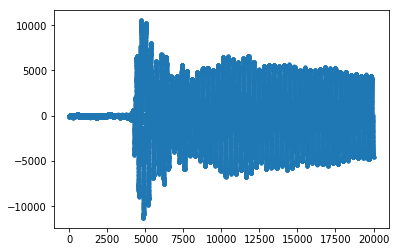

In [378]:
plt.plot(music.chan1[290000: 310000], '.')